In [1]:
import os
import numpy as np
import pandas as pd
from data_loader import read_data
from keras.utils import to_categorical
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, BatchNormalization, Dense
import matplotlib.pyplot as plt

from albert_zh.extract_feature import BertVector

Using TensorFlow backend.


#### 读取训练样本数据和测试样本数据

In [2]:
train_path,test_path = 'data/train.txt','data/test.txt'

labels, texts = read_data(train_path)
df_train = pd.DataFrame({'label': labels, 'text': texts})

labels, texts = read_data(test_path)
df_test = pd.DataFrame({'label': labels, 'text': texts})

df_train['text_len'] = df_train['text'].apply(lambda x: len(x))
#也就是在75%分位的时候，句子长度为102，所以往albert里面灌入的时候，max_seq_len设置为100即可
df_train.describe()

,text_len
count,280.000000
mean,79.085714
std,37.749597
min,11.000000
25%,49.000000
50%,75.500000
75%,102.250000
max,219.000000


#### 模型数据准备

In [3]:
# 直接从albert中价值预训练好的模型
bert_model = BertVector(pooling_strategy="REDUCE_MEAN", max_seq_len=100)

print('begin encoding')
#利用albert模型对汉字进行编码，生成词向量,这里面的[0]就代表只取第一位的cls的位置的embedding输出，albert的词向量长度是312
word_endoder = lambda text: bert_model.encode([text])["encodes"][0]
df_train['x'] = df_train['text'].apply(word_endoder)
df_test['x']  = df_test['text'].apply(word_endoder)
print('end encoding')
print(df_train.head())
x_train = np.array([vec for vec in df_train['x']])
x_test = np.array([vec for vec in df_test['x']])
y_train = np.array([vec for vec in df_train['label']])
y_test = np.array([vec for vec in df_test['label']])
print('x_train: ', x_train.shape)

# Convert class vectors to binary class matrices.
num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

I:BERT_VEC:[graph:opt: 48]:model config: D:\学习\ALBERT_text_classification\albert_zh/albert_tiny\albert_config_tiny.json
I:BERT_VEC:[graph:opt: 54]:build graph...


embedding_lookup_factorized. factorized embedding parameterization is used.
ln_type: postln
old structure of transformer.use: transformer_model,which use post-LN


I:BERT_VEC:[graph:opt:128]:load parameters from checkpoint...
I:BERT_VEC:[graph:opt:130]:freeze...
I:BERT_VEC:[graph:opt:133]:optimize...
I:BERT_VEC:[graph:opt:144]:write graph to a tmp file: ./tmp_graph11


begin encoding
end encoding
  label                                               text  text_len  \
0     1  当地时间2月10日，白宫发表声明称，美国总统特朗普及夫人梅拉尼娅将于2月24日至25日访问印...        65   
1     0  俄罗斯卫星通讯社11日最新消息，菲律宾总统杜特尔特已下令终止与美国间的《访问部队协定》(VFA)。        49   
2     1  据俄罗斯卫星网6日报道，土耳其总统发言人卡林表示，俄罗斯军事代表团将于近日访问安卡拉，讨论叙...        60   
3     0  先来说说什么是LPDDR5：要知道，手机中有两种内存颗粒，一种就是DRAM也就是大家常说的“...       107   
4     1  在疫情的关键时刻，出现了一件令人感动的事情，让我们明白这才是真正的好朋友，不惧疫情访问我国，...        58   

                                                   x  
0  [-1.248986, -0.45352226, -0.49957415, -0.35959...  
1  [-0.88039243, 0.11325179, -0.7906988, -0.60522...  
2  [-0.39357486, 0.36067888, -0.45000237, -0.2815...  
3  [-0.360646, -0.27317396, -0.28267634, -0.09917...  
4  [-0.7160378, -0.35247326, 0.09846301, -0.04384...  
x_train:  (280, 312)


#### 构建keras模型

In [4]:
# 创建模型
x_in = Input(shape=(312, ))
x_out = Dense(32, activation="relu")(x_in)
x_out = BatchNormalization()(x_out)
x_out = Dense(num_classes, activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=x_out)
print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# 模型训练以及评估
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=8, epochs=20)
#模型存储
model.save('visit_classify.h5')
print(model.evaluate(x_test, y_test))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 312)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                10016     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 10,210
Trainable params: 10,146
Non-trainable params: 64
_________________________________________________________________
None
Train on 280 samples, validate on 60 samples
Epoch 1/20
280/280 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.8250 - val_loss: 0.2602 - val_accuracy: 0.9667
Epoch 2/20
280/280 [==============================] - 0s 354

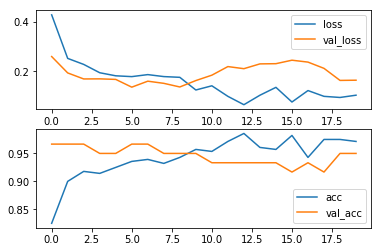

In [5]:
# 绘制loss和acc图像
plt.subplot(2, 1, 1)
epochs = len(history.history['loss'])
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
epochs = len(history.history['accuracy'])
plt.plot(range(epochs), history.history['accuracy'], label='acc')
plt.plot(range(epochs), history.history['val_accuracy'], label='val_acc')
plt.legend()
#plt.savefig("loss_acc.png")
plt.show()